In [101]:
import random
import numpy as np
import pandas as pd
from math import sqrt

import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

### Download and explore the data

In [2]:
df = pd.read_csv('data/bioresponse.csv', header=0)

In [3]:
df

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = df.drop(columns=['Activity'])
y = df['Activity']

In [5]:
# Split data into train and test sets. Train set is 75% of whole dataset
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.25, train_size=0.75, random_state=42)

In [14]:
# Convert y Series into DataFrame
test_y = pd.DataFrame(test_y)
train_y = pd.DataFrame(train_y)

In [15]:
# Reshape train y dataframe (2813 - number of samples = 75% of 3751 (total number of samples))
train_y = train_y.values.reshape(1, 2813)

In [16]:
# Reshape train y dataframe (938 - number of samples = 25% of 3751 (total number of samples))
test_y = test_y.values.reshape(1, 938)

## Logistic Regression

In [6]:
# Sigmoid function
def sigmoid(z):
    s = 1./(1.+np.exp(-z))
    return s

In [7]:
# Initialize with zeros function
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

In [8]:
# Propagate function
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [104]:
# Optimize function (parameter sgd is for calculation using Stochastic Gradient Descent)
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False, sgd=False):
    costs = []
    
    for i in range(num_iterations):
                
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        if sgd:
            if random.choice([True, False]):
                w -=learning_rate*dw
                b -=0
            else:
                w -=0
                b -=learning_rate*db
        else:
            w -=learning_rate*dw
            b -=learning_rate*db
        
        # Record the costs
#         if i % 100 == 0:
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [105]:
# Optimize function with Adam algorithm implementation
def adam_optimize(w, b, X, Y, num_iterations, learning_rate, beta1=0.9, beta2=0.999, eps=1e-8, print_cost=False):
    costs = []
    
    # initialize first and second moments
    m_w = [0.0 for _ in range(X.shape[0])]
    v_w = [0.0 for _ in range(X.shape[0])]
    m_b = 0.0
    v_b = 0.0
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        for j in range(X.shape[0]):
            # calculate the first moment
            m_w[j] = beta1 * m_w[j] + (1.0 - beta1) * dw[j][0]
            
            # calculate the second moment
            v_w[j] = beta2 * v_w[j] + (1.0 - beta2) * dw[j][0]**2
            
            # calculate bias-corrected first and second moments
            mhat_w = m_w[j] / (1.0 - beta1**(i+1))
            
            vhat_w = v_w[j] / (1.0 - beta2**(i+1))
            
            # update parameters
            w[j][0] = w[j][0] - learning_rate * mhat_w / (sqrt(vhat_w) + eps)

        v_b = beta2 * v_b + (1.0 - beta2) * db[0]**2
        m_b = beta1 * m_b + (1.0 - beta1) * db[0]
        mhat_b = m_b / (1.0 - beta1**(i+1))
        vhat_b = v_b / (1.0 - beta2**(i+1))
        b = b - learning_rate * mhat_b / (sqrt(vhat_b) + eps)
        
        # Record the costs
#         if i % 100 == 0:
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [87]:
# Predict function

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction

In [88]:
# model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False, sgd=False, adam=False):
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Adam optimization
    if adam:
        parameters, grads, costs = adam_optimize(w, b, X_train, Y_train, num_iterations, learning_rate, 
                                                 print_cost=print_cost)
    else:
        # Gradient descent and SGD
        parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost, sgd)
    
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [106]:
# Ordinary gradient descent
gd = model(train_X.T, train_y, test_X.T, test_y, num_iterations = 1000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.681095
Cost after iteration 200: 0.673994
Cost after iteration 300: 0.667662
Cost after iteration 400: 0.661794
Cost after iteration 500: 0.656314
Cost after iteration 600: 0.651172
Cost after iteration 700: 0.646329
Cost after iteration 800: 0.641754
Cost after iteration 900: 0.637419
train accuracy: 67.7568432278706 %
test accuracy: 69.40298507462687 %


In [107]:
# Stochastic gradient descent
sgd = model(train_X.T, train_y, test_X.T, test_y, num_iterations = 1000, learning_rate = 0.001, print_cost = True, 
          sgd=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.685299
Cost after iteration 200: 0.680625
Cost after iteration 300: 0.676421
Cost after iteration 400: 0.673663
Cost after iteration 500: 0.670634
Cost after iteration 600: 0.668086
Cost after iteration 700: 0.664674
Cost after iteration 800: 0.661736
Cost after iteration 900: 0.659555
train accuracy: 64.94845360824743 %
test accuracy: 68.7633262260128 %


In [108]:
# Adam
adm = model(train_X.T, train_y, test_X.T, test_y, num_iterations = 1000, learning_rate = 0.001, print_cost = True, 
          adam=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.498466
Cost after iteration 200: 0.439847
Cost after iteration 300: 0.406542
Cost after iteration 400: 0.383500
Cost after iteration 500: 0.365903
Cost after iteration 600: 0.351658
Cost after iteration 700: 0.339680
Cost after iteration 800: 0.329333
Cost after iteration 900: 0.320217
train accuracy: 87.23782438677569 %
test accuracy: 76.33262260127933 %


In [115]:
# Function for drawing the learning curve
def plot_process(iter_num, costs, algorithm, learning_rate):
    iters = np.array([i for i in range(iter_num)])
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(iters, costs, color='tab:blue')
    ax.grid()
    
    plt.title(f'{algorithm}, learning_rate = {learning_rate}')
    plt.xlabel('iterations')
    plt.ylabel('cost')

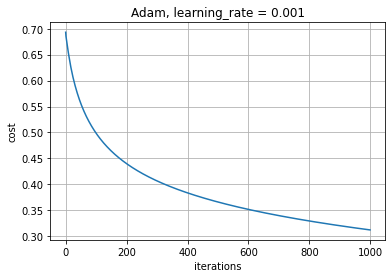

In [116]:
plot_process(adm['num_iterations'], adm['costs'], 'Adam', adm['learning_rate'])

In [122]:
# Set of different learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]


Gradient Descent, learning_rate = 0.1
train accuracy: 82.26093138997511 %
test accuracy: 76.97228144989339 %

Stochastic Gradient Descent, learning_rate = 0.1
train accuracy: 80.62566654816922 %
test accuracy: 76.86567164179104 %

Adam, learning_rate = 0.1


/Users/eshchepina/ITMO_code/ML_labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/eshchepina/ITMO_code/ML_labs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


train accuracy: 94.7742623533594 %
test accuracy: 72.70788912579957 %

Gradient Descent, learning_rate = 0.01
train accuracy: 77.10629221471739 %
test accuracy: 74.73347547974413 %

Stochastic Gradient Descent, learning_rate = 0.01
train accuracy: 75.11553501599715 %
test accuracy: 73.34754797441364 %

Adam, learning_rate = 0.01
train accuracy: 92.60575897618202 %
test accuracy: 74.73347547974413 %

Gradient Descent, learning_rate = 0.001
train accuracy: 67.7568432278706 %
test accuracy: 69.40298507462687 %

Stochastic Gradient Descent, learning_rate = 0.001
train accuracy: 64.912904372556 %
test accuracy: 68.86993603411514 %

Adam, learning_rate = 0.001
train accuracy: 87.23782438677569 %
test accuracy: 76.33262260127933 %

Gradient Descent, learning_rate = 0.0001
train accuracy: 53.288304301457515 %
test accuracy: 57.0362473347548 %

Stochastic Gradient Descent, learning_rate = 0.0001
train accuracy: 53.288304301457515 %
test accuracy: 57.0362473347548 %

Adam, learning_rate = 0.0001

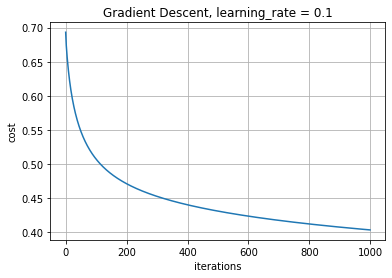

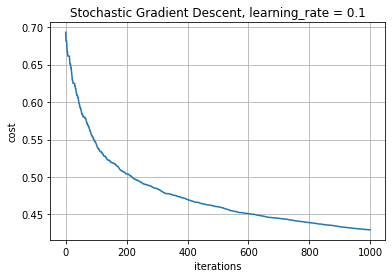

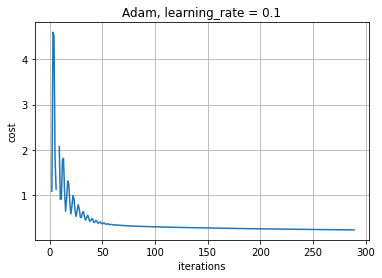

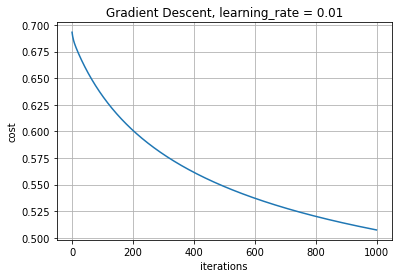

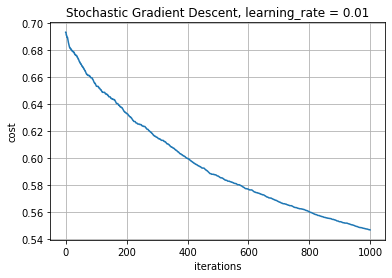

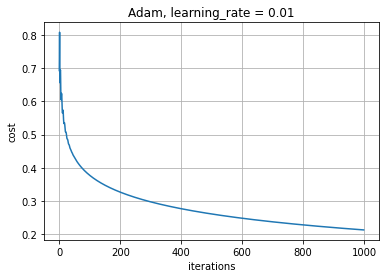

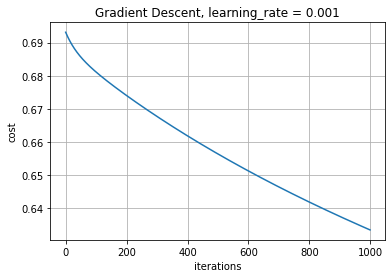

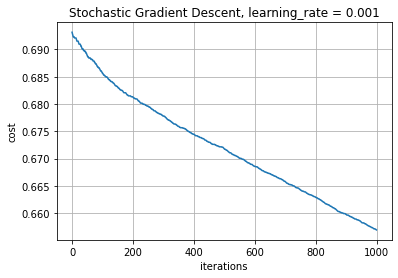

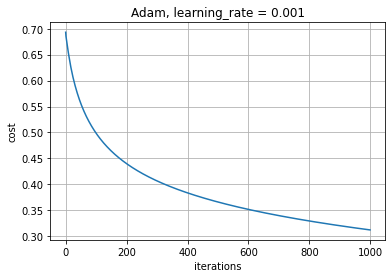

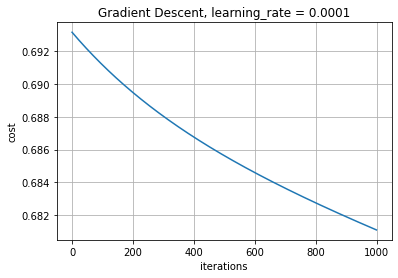

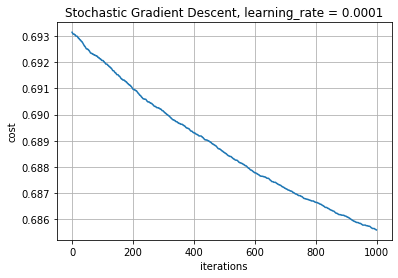

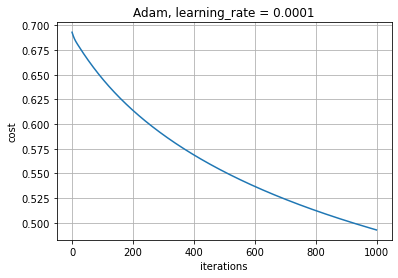

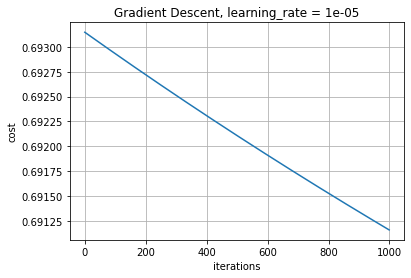

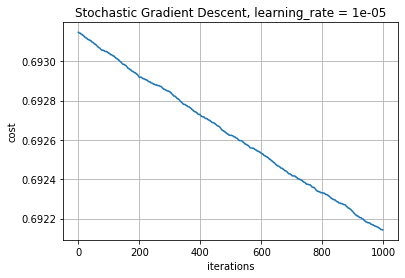

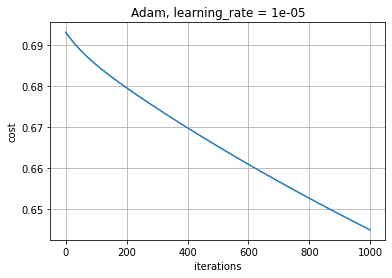

In [124]:
# Apply different learning rates to the different types of optimize() function and show the results
for learning_rate in learning_rates:
    print(f'\nGradient Descent, learning_rate = {learning_rate}')
    gd = model(train_X.T, train_y, test_X.T, test_y, num_iterations = 1000, learning_rate=learning_rate, 
               print_cost=False) 
    plot_process(gd['num_iterations'], gd['costs'], 'Gradient Descent', gd['learning_rate'])
    
    print(f'\nStochastic Gradient Descent, learning_rate = {learning_rate}')
    sgd = model(train_X.T, train_y, test_X.T, test_y, num_iterations = 1000, learning_rate=learning_rate, 
                print_cost=False, sgd=True)
    plot_process(sgd['num_iterations'], sgd['costs'], 'Stochastic Gradient Descent', sgd['learning_rate'])
    
    print(f'\nAdam, learning_rate = {learning_rate}')
    adm = model(train_X.T, train_y, test_X.T, test_y, num_iterations = 1000, learning_rate=learning_rate, 
                print_cost=False, adam=True)
    plot_process(adm['num_iterations'], adm['costs'], 'Adam', adm['learning_rate'])

#### Conclusions about an impact of learning rate:


Gradient descent and Stochastic gradient descent - with an increase in the learning rate, the accuracy decreases.


Adam - the best accuracy for learning rate = 0.001 (the middle of our set). With small and big values of learning rate the accuracy decreases.